**Chapter 1 – The Machine Learning landscape**

_This is the code used to generate some of the figures in chapter 1._

# Code example 1-1

Although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead.

In [396]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

In [397]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

This function just merges the OECD's life satisfaction data and the IMF's GDP per capita data. It's a bit too long and boring and it's not specific to Machine Learning, which is why I left it out of the book.

## Description CSDC

The following code fragment accepts the dataframes for the 'Better life index' and the GDP as input parameters, then merges the dataframes on the country.

The reason why he drop severals data sets is not quite clear, but we add Austria to the locations to be dropped from the frame to avoid biassing the training set.

In [398]:
def prepare_country_stats(oecd_bli, gdp_per_capita):

    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    austria_loc = full_country_stats.index.get_loc("Austria")
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    remove_indices.append(austria_loc)
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

The code in the book expects the data files to be located in the current directory. I just tweaked it here to fetch the files in datasets/lifesat.

In [399]:
import os
datapath = os.path.join("datasets", "lifesat", "")

In [400]:
# To plot pretty figures directly within Jupyter
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [401]:
# Download the data
import urllib.request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
os.makedirs(datapath, exist_ok=True)
for filename in ("oecd_bli_2015.csv", "gdp_per_capita.csv"):
    print("Downloading", filename)
    url = DOWNLOAD_ROOT + "datasets/lifesat/" + filename
    urllib.request.urlretrieve(url, datapath + filename)

## Linear Regression - Description CSDC

The previously defined method is called and a dataframe containing Country as index, GDP and life satisfaction is retrieved. The training set is then extracted from the dataframe, X being the training data and y the corresponding label.

The stats are then plotted as a scatter plot.

The model is then trained via `model.fit()` with X and y, furthermore a prediction is made for austria via `model.predict()`.

Furthermore we've predicted the y for all values that were previously already fed to the model. Since the model already knows these values, this only makes sense for graphical purposes. Ideally we would have a test set, on which we run the prediction on to see the performance of the model. 

Since the training set is already very small, we did not split it any further into training and test set, as in that case, we'd just give more way to overfitting, but we're very much aware that this would be required and optimally go even further by splitting it into training, test and validation set.

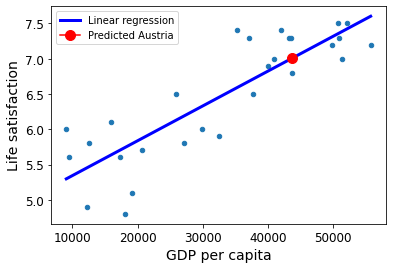

In [402]:
# Code example
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

# Load the data
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv",thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")

# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]


# Select a linear model
model = sklearn.linear_model.LinearRegression()

# Train the model
model.fit(X, y)

# Make a prediction for Austria
X_austria = [[43724.031]]  # Austria' GDP per capita
austria_prediciton = model.predict(X_austria) # outputs [[7.00612271]]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
predicted_values = model.predict(X)
plt.plot(X, predicted_values, color='blue', linewidth=3, label='Linear regression')
plt.plot(X_austria, austria_prediciton, color='red', marker='o', markersize=10, label="Predicted Austria")
#plt.gca().set_ylim(bottom=0)
#plt.gca().set_ylim(top=10)
plt.legend()
plt.show()



## Polynomial Regression - Description CSDC

In summary polynomial regression functions similar to linear regression / regression with 1st degree polynomials only. Using polynomial regression allows the regression to make use of higher order polynomials (capped with a setting), as well as combinations of the features (1, a, b, a^2, ab, b^2, ...). 

Doing so allows the regression to better fit to the dataset, but allowing too high order polynomials also increases the risk of overfitting.

We define the 
* PolynomialFeatures, which cap the allowed polynomial degree
* StandardScaler, which helps to smooth out the curve by standardizing features removing the mean and scaling to unit variance
* LinearRegression, as used above
* Pipeline, which determines in which order the mentioned components are applied, the pipeline is then used to fit the model (via the final estimator), as well as predict the model.

Initially we would have chosen 4th degree polynomials, since it fit the data quite well, but we've seen that quadratic features were requsted. We've added both as a separate plot to display the difference.



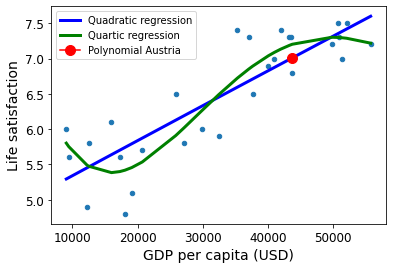

In [415]:
from sklearn import preprocessing
from sklearn import pipeline

# Set up components
poly_2 = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly_4 = preprocessing.PolynomialFeatures(degree=4, include_bias=False)
scaler_2 = preprocessing.StandardScaler()
scaler_4 = preprocessing.StandardScaler()
lin_reg_2 = linear_model.LinearRegression()
lin_reg_4 = linear_model.LinearRegression()

# Apply components
pipeline_reg_2 = pipeline.Pipeline([('poly', poly_2), ('scal', scaler_2), ('lin', lin_reg_2)])
pipeline_reg_4 = pipeline.Pipeline([('poly', poly_4), ('scal', scaler_4), ('lin', lin_reg_4)])

# Fit the model
pipeline_reg_2.fit(X, y)
pipeline_reg_4.fit(X, y)

# Make a prediction for Austria
X_austria_poly = [[43724.031]]  # Austria' GDP per capita
austria_prediction_poly_2 = pipeline_reg_2.predict(X_austria_poly) # outputs [[7.16886356]]
austria_prediction_poly_4 = pipeline_reg_4.predict(X_austria_poly) # outputs [[7.16886356]]

# Predict for all
curve_2 = pipeline_reg_2.predict(X)
curve_4 = pipeline_reg_4.predict(X)

# Plot the results
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.plot(X, curve_2,color='blue', linewidth=3, label='Quadratic regression')
plt.plot(X, curve_4,color='green', linewidth=3, label='Quartic regression')
plt.plot(X_austria_poly, austria_prediction_poly_2, color='red', marker='o', markersize=10, label="Polynomial Austria")
plt.xlabel("GDP per capita (USD)")
plt.legend()
plt.show()


# Note: you can ignore the rest of this notebook, it just generates many of the figures in chapter 1.

Create a function to save the figures.

In [ ]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "fundamentals"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Make this notebook's output stable across runs:

In [ ]:
np.random.seed(42)

# Load and prepare Life satisfaction data

If you want, you can get fresh data from the OECD's website.
Download the CSV from http://stats.oecd.org/index.aspx?DataSetCode=BLI
and save it to `datasets/lifesat/`.

In [ ]:
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
oecd_bli.head(2)

In [ ]:
oecd_bli["Life satisfaction"].head()

# Load and prepare GDP per capita data

Just like above, you can update the GDP per capita data if you want. Just download data from http://goo.gl/j1MSKe (=> imf.org) and save it to `datasets/lifesat/`.

In [ ]:
gdp_per_capita = pd.read_csv(datapath+"gdp_per_capita.csv", thousands=',', delimiter='\t',
                             encoding='latin1', na_values="n/a")
gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
gdp_per_capita.set_index("Country", inplace=True)
gdp_per_capita.head(2)

In [ ]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, left_index=True, right_index=True)
full_country_stats.sort_values(by="GDP per capita", inplace=True)
full_country_stats

In [ ]:
full_country_stats[["GDP per capita", 'Life satisfaction']].loc["United States"]

In [ ]:
remove_indices = [0, 1, 6, 8, 33, 34, 35]
keep_indices = list(set(range(36)) - set(remove_indices))

sample_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]
missing_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]

In [ ]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])
position_text = {
    "Hungary": (5000, 1),
    "Korea": (18000, 1.7),
    "France": (29000, 2.4),
    "Australia": (40000, 3.0),
    "United States": (52000, 3.8),
}
for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = sample_data.loc[country]
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "ro")
plt.xlabel("GDP per capita (USD)")
save_fig('money_happy_scatterplot')
plt.show()

In [ ]:
sample_data.to_csv(os.path.join("datasets", "lifesat", "lifesat.csv"))

In [ ]:
sample_data.loc[list(position_text.keys())]

In [ ]:
import numpy as np

sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, 2*X/100000, "r")
plt.text(40000, 2.7, r"$\theta_0 = 0$", fontsize=14, color="r")
plt.text(40000, 1.8, r"$\theta_1 = 2 \times 10^{-5}$", fontsize=14, color="r")
plt.plot(X, 8 - 5*X/100000, "g")
plt.text(5000, 9.1, r"$\theta_0 = 8$", fontsize=14, color="g")
plt.text(5000, 8.2, r"$\theta_1 = -5 \times 10^{-5}$", fontsize=14, color="g")
plt.plot(X, 4 + 5*X/100000, "b")
plt.text(5000, 3.5, r"$\theta_0 = 4$", fontsize=14, color="b")
plt.text(5000, 2.6, r"$\theta_1 = 5 \times 10^{-5}$", fontsize=14, color="b")
save_fig('tweaking_model_params_plot')
plt.show()

In [ ]:
from sklearn import linear_model
lin1 = linear_model.LinearRegression()
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]
lin1.fit(Xsample, ysample)
t0, t1 = lin1.intercept_[0], lin1.coef_[0][0]
t0, t1

In [ ]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.text(5000, 3.1, r"$\theta_0 = 4.85$", fontsize=14, color="b")
plt.text(5000, 2.2, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="b")
save_fig('best_fit_model_plot')
plt.show()


In [ ]:
cyprus_gdp_per_capita = gdp_per_capita.loc["Cyprus"]["GDP per capita"]
print(cyprus_gdp_per_capita)
cyprus_predicted_life_satisfaction = lin1.predict([[cyprus_gdp_per_capita]])[0][0]
cyprus_predicted_life_satisfaction

In [ ]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3), s=1)
plt.xlabel("GDP per capita (USD)")
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.axis([0, 60000, 0, 10])
plt.text(5000, 7.5, r"$\theta_0 = 4.85$", fontsize=14, color="b")
plt.text(5000, 6.6, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="b")
plt.plot([cyprus_gdp_per_capita, cyprus_gdp_per_capita], [0, cyprus_predicted_life_satisfaction], "r--")
plt.text(25000, 5.0, r"Prediction = 5.96", fontsize=14, color="b")
plt.plot(cyprus_gdp_per_capita, cyprus_predicted_life_satisfaction, "ro")
save_fig('cyprus_prediction_plot')
plt.show()

In [ ]:
sample_data[7:10]

In [ ]:
(5.1+5.7+6.5)/3

In [ ]:
backup = oecd_bli, gdp_per_capita

def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

In [ ]:
# Code example
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

# Load the data
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv",thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")

# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.show()

# Select a linear model
model = sklearn.linear_model.LinearRegression()

# Train the model
model.fit(X, y)

# Make a prediction for Cyprus
X_new = [[22587]]  # Cyprus' GDP per capita
print(model.predict(X_new)) # outputs [[ 5.96242338]]

In [ ]:
oecd_bli, gdp_per_capita = backup

In [ ]:
missing_data

In [ ]:
position_text2 = {
    "Brazil": (1000, 9.0),
    "Mexico": (11000, 9.0),
    "Chile": (25000, 9.0),
    "Czech Republic": (35000, 9.0),
    "Norway": (60000, 3),
    "Switzerland": (72000, 3.0),
    "Luxembourg": (90000, 3.0),
}

In [ ]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

X=np.linspace(0, 110000, 1000)
plt.plot(X, t0 + t1*X, "b:")

lin_reg_full = linear_model.LinearRegression()
Xfull = np.c_[full_country_stats["GDP per capita"]]
yfull = np.c_[full_country_stats["Life satisfaction"]]
lin_reg_full.fit(Xfull, yfull)

t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_[0][0]
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "k")
plt.xlabel("GDP per capita (USD)")

save_fig('representative_training_data_scatterplot')
plt.show()

In [ ]:
full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

from sklearn import preprocessing
from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=60, include_bias=False)
scaler = preprocessing.StandardScaler()
lin_reg2 = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly', poly), ('scal', scaler), ('lin', lin_reg2)])
pipeline_reg.fit(Xfull, yfull)
curve = pipeline_reg.predict(X[:, np.newaxis])
plt.plot(X, curve)
plt.xlabel("GDP per capita (USD)")
save_fig('overfitting_model_plot')
plt.show()

In [ ]:
full_country_stats.loc[[c for c in full_country_stats.index if "W" in c.upper()]]["Life satisfaction"]

In [ ]:
gdp_per_capita.loc[[c for c in gdp_per_capita.index if "W" in c.upper()]].head()

In [ ]:
plt.figure(figsize=(8,3))

plt.xlabel("GDP per capita")
plt.ylabel('Life satisfaction')

plt.plot(list(sample_data["GDP per capita"]), list(sample_data["Life satisfaction"]), "bo")
plt.plot(list(missing_data["GDP per capita"]), list(missing_data["Life satisfaction"]), "rs")

X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "r--", label="Linear model on all data")
plt.plot(X, t0 + t1*X, "b:", label="Linear model on partial data")

ridge = linear_model.Ridge(alpha=10**9.5)
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]
ridge.fit(Xsample, ysample)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_[0][0]
plt.plot(X, t0ridge + t1ridge * X, "b", label="Regularized linear model on partial data")

plt.legend(loc="lower right")
plt.axis([0, 110000, 0, 10])
plt.xlabel("GDP per capita (USD)")
save_fig('ridge_model_plot')
plt.show()